In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys


sys.path.append("../functions")

from Utility import *
from Plotting import *

%matplotlib inline
# %load_ext jupyter_black

# plt.style.use("../matplotlib_style.txt")

In [16]:
import scipy 
color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame()):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

## Read Data and Preprocessing 

In [2]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

## Fitting Backward and Forward

In [3]:
from Fitting import fit_for_all_subjects
from Forward import forward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 100
n_threads = 100
res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, lv_induction_data, forward_fitting
)
forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
forward_df["hbound"] = (5 - forward_df["lbound"]) * (
    forward_df["bound_range"]
) + forward_df["lbound"]

forward_df.to_csv("../results/forward_df.csv")

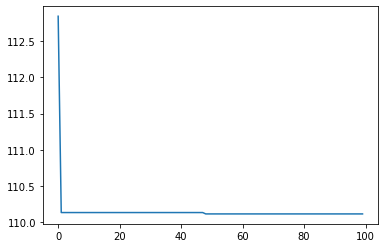

In [18]:

min_neg_lls = np.zeros((len(subjects), n_fitting))
for i, r in enumerate(res):
    min_neg_lls[i, :] = r[1]

plt.plot(np.mean(min_neg_lls, axis=0))
plt.show()

In [5]:
from Backward import backward_fitting_unscaled

params_ranges = [[0, 1], [0, 100]]

back_res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, lv_induction_data, backward_fitting_unscaled
)
backward_df_unscaled = make_df_after_fitting(
    back_res, ["alpha", "beta"], subjects
)
backward_df_unscaled["hbound"] = 1

backward_df_unscaled["hbound"] = 5

backward_df_unscaled.to_csv("../results/backward_df_unscaled.csv")

In [20]:
backward_df_unscaled

,subject,alpha,beta,LL,Confidence Distance,hbound
0,45628.0,1.000000,8.851364,141.843910,1.935191,5
1,45640.0,0.655386,9.894172,134.285292,1.178608,5
2,45664.0,0.002438,51.463480,274.803159,1.554254,5
3,45682.0,0.859821,5.764763,167.637278,0.758225,5
4,45745.0,1.000000,9.003098,188.935741,1.874369,5
5,45760.0,0.728764,15.113237,90.539471,0.555175,5
6,45763.0,0.927836,10.401031,73.091062,1.012083,5
7,45805.0,1.000000,6.751710,206.526741,2.537447,5
8,45829.0,1.000000,6.569182,135.295964,0.779431,5
9,45964.0,0.582176,8.046393,148.465333,0.829102,5


In [4]:
from Backward import backward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]


back_res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, lv_induction_data, backward_fitting
)
backward_df = make_df_after_fitting(
    back_res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
backward_df["hbound"] = (5 - backward_df["lbound"]) * (
    backward_df["bound_range"]
) + backward_df["lbound"]

backward_df.to_csv("../results/backward_df.csv")

In [10]:
from Fitting import fit_brier

brier_res = fit_brier(subjects, lv_induction_data, n_threads=n_threads)
scaled_brier_ls = []
scaled_brier_lb = []
scaled_brier_ub = []
for res in brier_res:
    scaled_brier_ls.append(res[1])
    scaled_brier_lb.append(res[0][0])
    scaled_brier_ub.append(res[0][1] * (1 - res[0][0]) + res[0][0])
scaled_brier_df = pd.DataFrame(
    list(zip(subjects, scaled_brier_lb, scaled_brier_ub, scaled_brier_ls)),
    columns=["subject", "lb", "ub", "brier"],
)
scaled_brier_df["scaled_QSR"] = 1 - scaled_brier_df["brier"]
scaled_brier_df.to_csv("../results/scaled_brier_df.csv")

## Results

In [18]:
forward_df = pd.read_csv("../results/forward_df.csv")
backward_df = pd.read_csv("../results/backward_df.csv")

Statistics=27.0, p=4.717290906942734e-08
Statistics=531.0, p=0.06859756863791937


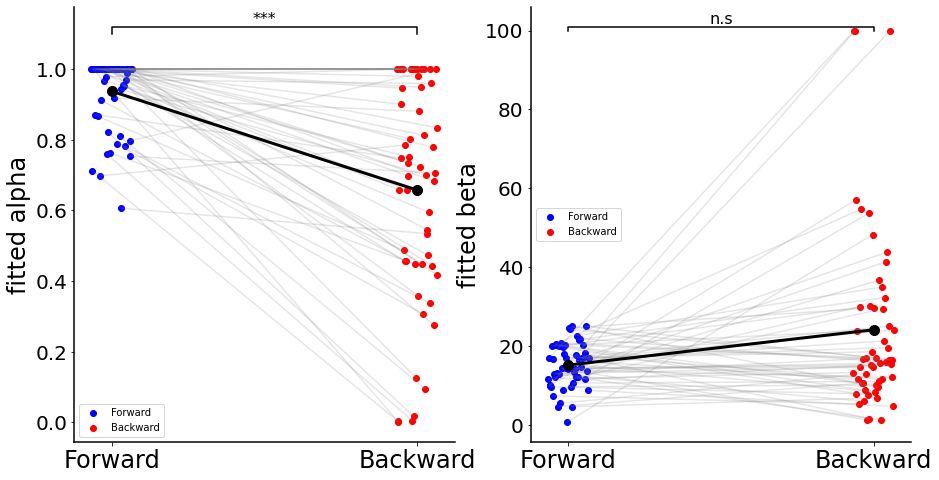

In [8]:
from Plotting import comparison_plot
from Utility import merge_result_df

groups = ["Forward", "Backward"]
df = merge_result_df([forward_df, backward_df], groups, 400, subjects)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
comparison_plot(
    df,
    "alpha",
    groups,
    "",
    [["Forward", "Backward"]],
    [1.1],
    [0.02],
    y_label="fitted alpha",
)
plt.subplot(1, 2, 2)
comparison_plot(
    df,
    "beta",
    groups,
    "",
    [["Forward", "Backward"]],
    [100],
    [1],
    y_label="fitted beta",
)

plt.savefig("../figs/alpha_beta.png")

Statistics for Forward and Backward =367.0, p=2.341e-02
mean Forward = 2.35
mean Backward = 2.15
Statistics for Forward and Backward =353.0, p=7.974e-04
mean Forward = 4.26
mean Backward = 4.51


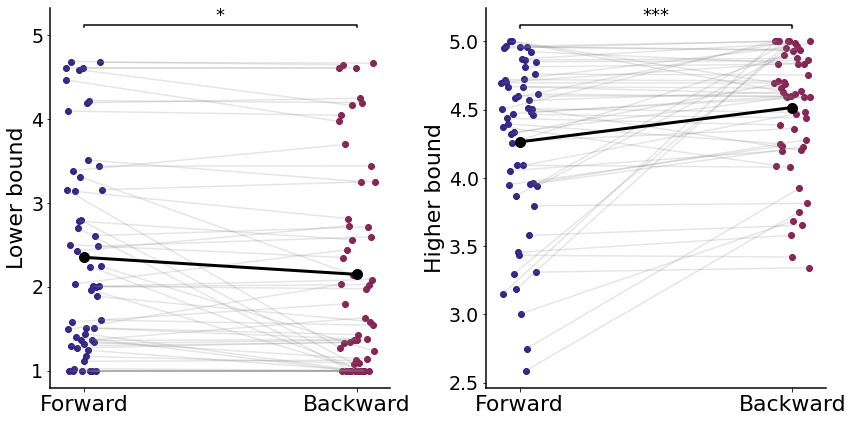

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
comparison_plot(
    df,
    "lbound",
    groups,
    "",
    [["Forward", "Backward"]],
    [5.1],
    [0.02],
    y_label="Lower bound",
)
plt.subplot(1, 2, 2)
comparison_plot(
    df,
    "hbound",
    groups,
    "",
    [["Forward", "Backward"]],
    [5.1],
    [0.02],
    y_label="Higher bound",
)
plt.tight_layout()

plt.savefig("../figs/bounds.png", dpi=400, bbox_inches = "tight")


Statistics=381.0, p=0.0030639335709374076


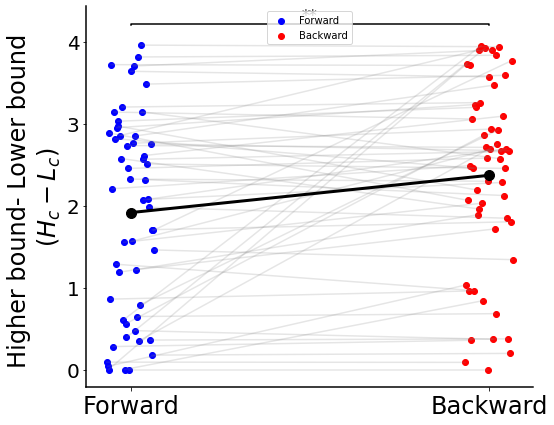

In [14]:
plt.figure(figsize=(8, 7))
df["Bound_Range"] = df["hbound"] - df["lbound"]
comparison_plot(
    df,
    "Bound_Range",
    groups,
    "",
    [["Forward", "Backward"]],
    [4.2],
    [0.02],
    y_label="Higher bound- Lower bound \n" + r"$(H_c - L_c$)",
)
plt.savefig("../figs/hc_lc.png", dpi=400)

Statistics=0.0, p=1.6256984569330967e-10


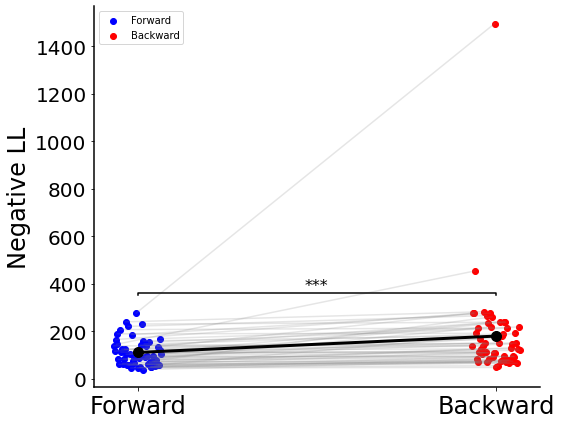

In [15]:
plt.figure(figsize=(8, 7))
# plt.subplot(1, 2, 1)
comparison_plot(
    df, "LL", groups, "", [["Forward", "Backward"]], [350], [10], y_label="Negative LL"
)
plt.savefig("../figs/neg_LL_compare.png", dpi=400)

Statistics=1.0, p=1.7198462727875601e-10


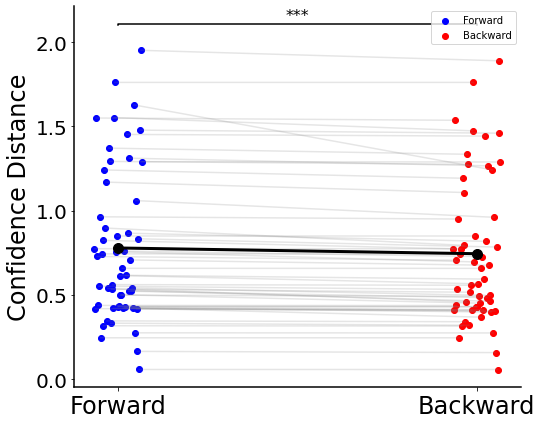

In [16]:
plt.figure(figsize=(8, 7))
# plt.subplot(1, 2, 1)
comparison_plot(
    df,
    "Confidence Distance",
    groups,
    "",
    [["Forward", "Backward"]],
    [2.1],
    [0.01],
    y_label="Confidence Distance",
    legend="upper right",
)
plt.savefig("../figs/conf_dist_compare.png", dpi=400)